In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
scratch = "/pscratch/sd/t/timothys"

In [4]:
metric = "RMSE"
rmse = {}
varnames = ["surface_pressure", "2m_temperature", "10m_zonal_wind", "10m_meridional_wind", "500hpa_geopotential_height", "850hpa_temperature", "250hpa_zonal_wind", "250hpa_zonal_wind"]

rmse["Nested-EAGLE 1\u00B0/15km"] = xr.Dataset({
    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/mse06h/experiments/training-steps/steps030k/inference-validation/obs-val-global/{varname}.nc")[metric]
    for varname in varnames
})

rmse["GFS 1\u00B0"] = xr.Dataset({
    varname: xr.load_dataset(f"{scratch}/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-val/{varname}.nc")[metric]
    for varname in varnames
})

rmse["Global-EAGLE Anemoi 1\u00B0"] = xr.Dataset({
    varname: xr.load_dataset(f"/pscratch/sd/t/timothys/anemoi-house/gfs/1.00-degree/latlon/steps030k/inference-validation/obs-val/{varname}.nc")[metric]
    for varname in varnames
})


In [5]:
nice_names = {
    "surface_pressure": "Surface Pressure (Pa)",
    "2m_temperature": "2m Temperature (\u00B0C)",
    "10m_zonal_wind": "10m Zonal Wind (m s$^{-1}$)",
    "10m_meridional_wind": "10m Meridional Wind (m s$^{-1}$)",
    "500hpa_geopotential_height": "500 hPa Geopotential Height (m)",
    "850hpa_temperature": "850 hPa Temperature (\u00B0C)",
    "250hpa_zonal_wind": "250 hPa Zonal Wind (m s$^{-1}$)",
    "250hpa_meridional_wind": "250 hPa Meridional Wind (m s$^{-1}$)",
}

In [6]:
def get_color(name):
    if "nested-eagle" in name.lower():
        return "C0"
    elif "gfs" in name.lower():
        return "C2"
    elif "hrrr" in name.lower():
        return "C1"
    elif "global-eagle" in name.lower():
        return "C4"
    elif "gefs" in name.lower():
        return "C3"
        

In [7]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in dsdict.items():
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=get_color(label),
            legend=False,
            **kwargs,
        )
    dt = 24
    if sel is not None:
        if sel.get("fhr", None) is not None:
            dt = 6
    last_time = 240 if dt == 24 else 48
    xticks = np.arange(0, last_time+1, dt)
    xticklabels = xticks//24 if dt == 24 else xticks #plotme.fhr.values
    units = "days" if dt == 24 else "hours"
    #xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.text(.05, .9, nice_names[varname], transform=ax.transAxes, ha="left", va="center")
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel=f"Lead Time ({units})" if ax.get_subplotspec().is_last_row() else "",
        title="",#nice_names[varname],# if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
        xticklabels=xticklabels,
    )
    #ax.legend(frameon=False)

[Text(0, 0.5, 'RMSE vs Conventional Obs')]

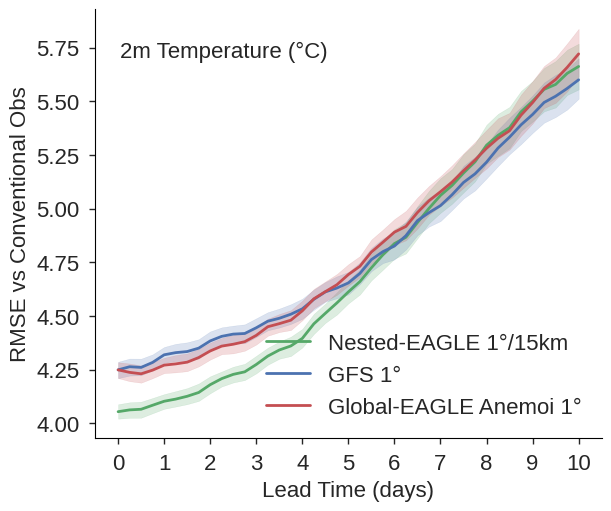

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True, sharex=True)
    
single_plot(ax=ax, dsdict=rmse, varname="2m_temperature")
handles, labels = ax.get_legend_handles_labels()
ax.legend(frameon=False, loc="lower right")
ax.set(ylabel="RMSE vs Conventional Obs")
#fig.legend(handles, labels, bbox_to_anchor=(1., .6), loc='center left', fontsize='large', frameon=False)

/tmp/ipykernel_598088/3405986787.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])


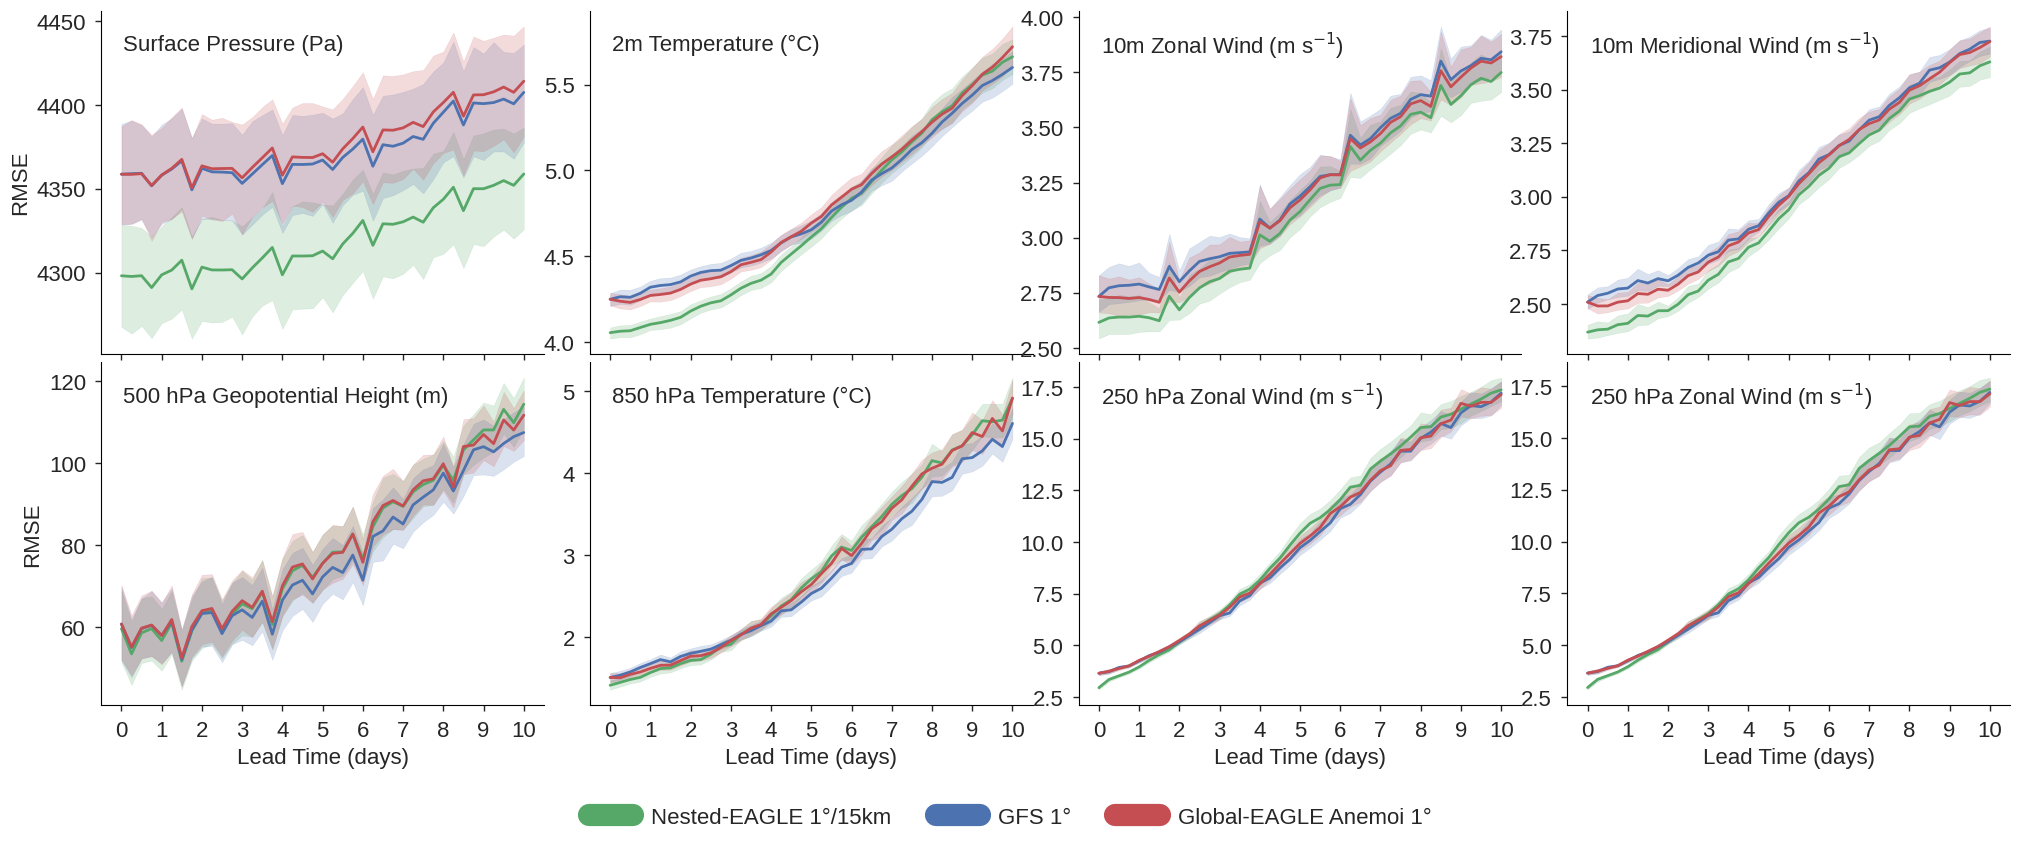

In [37]:
nvars = len(varnames)
nrows = 2
ncols = np.ceil(nvars / nrows).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True, sharex=True)
    
for varname, ax in zip(varnames, axs.flatten()):
    single_plot(ax=ax, dsdict=rmse, varname=varname)
handles, labels = axs[0, 0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncols=len(labels),
    frameon=False,
)
for line in legend.get_lines():
    line.set_linewidth(16)
plt.tight_layout(pad=0, rect=[0, 0.05, 1, 1])
#fig.legend(handles, labels, bbox_to_anchor=(1., .6), loc='center left', fontsize='large', frameon=False)